In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Prepare the Data
# Load the main data from the CSV file
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Twente 1-0 Almere.csv")

# Step 2: Process Qualifiers for 'endX' and 'endY'
# Identify columns containing qualifier IDs
type_cols = [col for col in df.columns if '/qualifierId' in col]

# Initialize 'endX' and 'endY' columns with 0.0
df['endX'] = 0.0
df['endY'] = 0.0

# Iterate through each row to find and set 'endX' and 'endY' values
for i in range(len(df)):
    df1 = df.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 140:  # Qualifier ID for endX
            endx = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'endX'] = endx
        elif col == 141:  # Qualifier ID for endY
            endy = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'endY'] = endy

# Step 3: Sort Events by Timestamp
# Ensure events are sorted in chronological order if there's a timestamp column
if 'timeStamp' in df.columns:
    df = df.sort_values(by='timeStamp')

# Convert timestamp to datetime format (remove timezone)
if df['timeStamp'].dtype != 'datetime64[ns]':
    df['timeStamp'] = pd.to_datetime(df['timeStamp'], utc=True).dt.tz_localize(None)  # Removes timezone

# Step 4: Identify Sequences
# Initialize sequence tracking
sequences = []
current_sequence = []
current_contestant = None
sequence_id = 1  # Unique identifier for each sequence

# Iterate over the DataFrame rows
for _, row in df.iterrows():
    if current_contestant is None or row['contestantId'] == current_contestant:
        # Append action to current sequence
        current_sequence.append(row)
    else:
        # New contestantId → Store the previous sequence if it ends with a shot
        if current_sequence:
            last_action = current_sequence[-1]
            if last_action['typeId'] in [13, 14, 15, 16]:  # Check if last action was a shot
                seq_df = pd.DataFrame(current_sequence)

                # Calculate event duration (time difference between events)
                seq_df['event_duration'] = seq_df['timeStamp'].diff().fillna(pd.Timedelta(seconds=0))

                # Add sequenceId column
                seq_df['sequenceId'] = sequence_id
                sequence_id += 1

                sequences.append(seq_df)
        
        current_sequence = [row]  # Start new sequence
    
    # Update current contestant
    current_contestant = row['contestantId']

# Append last sequence if it exists and ends with a shot
if current_sequence:
    last_action = current_sequence[-1]
    if last_action['typeId'] in [13, 14, 15, 16]:
        seq_df = pd.DataFrame(current_sequence)

        # Calculate event duration
        seq_df['event_duration'] = seq_df['timeStamp'].diff().fillna(pd.Timedelta(seconds=0))

        # Add sequenceId column
        seq_df['sequenceId'] = sequence_id

        sequences.append(seq_df)

# Combine all sequences into a single DataFrame
if sequences:
    final_df = pd.concat(sequences, ignore_index=True)

    # Calculate the contribution of each action in the sequence
    final_df['contribution'] = 0.0

    for seq_id in final_df['sequenceId'].unique():
        seq = final_df[final_df['sequenceId'] == seq_id]
        num_actions = len(seq)
        for i, (index, row) in enumerate(seq.iterrows()):
            # Assign higher weight to actions closer to the shot
            final_df.at[index, 'contribution'] = (i + 1) / num_actions

# Step 5: Identify Pressing Events
# Define event type IDs
PASS_EVENTS = {1}  # Adjust if needed
PRESSING_EVENTS = {7, 8, 44, 45, 49}

# Sort events by period, time, and sequence
df = df.sort_values(by=["periodId", "timeMin", "timeSec"])

# Shift previous event details (for contestantId and typeId)
df["prev_contestantId"] = df["contestantId"].shift(1)
df["prev_typeId"] = df["typeId"].shift(1)

# Filter pressing events where the previous event was a pass by the other team
pressing_events = df[
    (df["typeId"].isin(PRESSING_EVENTS)) & 
    (df["prev_typeId"].isin(PASS_EVENTS)) & 
    (df["contestantId"] != df["prev_contestantId"])  # Different team
]

# Count pressing events by player
pressing_count = pressing_events.groupby(["contestantId", "playerName"])["id"].count().reset_index()
pressing_count.rename(columns={"id": "Pressures"}, inplace=True)

# Map contestantId to team names
pressing_count["team"] = pressing_count["contestantId"]

# Calculate Pressures per 90 minutes (PP90)
total_minutes = df["timeMin"].max()  # Assuming match is complete
pressing_count["PP90"] = (pressing_count["Pressures"] / total_minutes) * 90

# Step 6: Identify Defensive Interventions
# Define defensive actions that disrupt attacks
defensive_actions = ['7', '8']  # Replace with actual event type IDs for defensive actions

# Debugging: Print unique typeId values to verify defensive actions
print("Unique typeId values:", df['typeId'].unique())

# Create a column to mark defensive interventions
df['defensive_intervention'] = df['typeId'].astype(str).isin(defensive_actions)

# Debugging: Print defensive interventions to verify
print("Defensive Interventions:")
print(df[df['defensive_intervention']][['typeId', 'defensive_intervention']].head())

# Step 7: Merge Pressures and Defensive Interventions
# Ensure sequences_df has the defensive_intervention column
if 'contestantId' in df.columns and 'contestantId' in final_df.columns:
    final_df = final_df.merge(
        df[['contestantId', 'defensive_intervention']],  # Select relevant columns
        on='contestantId',  # Merge on contestantId
        how='left'  # Keep all rows from sequences_df
    )
else:
    raise KeyError("'contestantId' not found in one or both DataFrames. Please check column names.")

# Step 8: Calculate Disruption for Each Sequence
def calculate_disruption(sequence):
    """
    Calculate whether a sequence was disrupted by defensive interventions.
    """
    if sequence['defensive_intervention'].any():
        # If there's a defensive intervention, mark the sequence as disrupted
        return 1
    else:
        return 0

# Apply the function to each sequence
sequence_disruption = final_df.groupby('sequenceId').apply(calculate_disruption).reset_index(name='disrupted')

# Step 9: Merge Disruption Values Back into the Main Data
final_df = final_df.merge(sequence_disruption[['sequenceId', 'disrupted']], on='sequenceId', how='left')

# Step 10: Aggregate Disruption Value by Player
# Group by player and calculate total disruptions caused
player_disruption = final_df.groupby(['playerName', 'contestantId']).agg(
    total_disruptions=('disrupted', 'sum'),
    defensive_actions=('defensive_intervention', 'sum')
).reset_index()

# Calculate disruption value per action
player_disruption['disruption_per_action'] = player_disruption['total_disruptions'] / player_disruption['defensive_actions']

# Sort players by total disruptions
player_disruption = player_disruption.sort_values(by='total_disruptions', ascending=False)

# Step 11: Calculate Disruption Percentage per Player
# Calculate total disruption per contestantId
total_disruption_per_contestant = player_disruption.groupby('contestantId')['total_disruptions'].transform('sum')

# Calculate disruption percentage per player
player_disruption['disruption_percentage'] = (player_disruption['total_disruptions'] / total_disruption_per_contestant) * 100

# Step 12: Save Results to Excel
# Create a Pandas Excel writer object
with pd.ExcelWriter("match_analysis_results.xlsx") as writer:
    # Save final_df to the first sheet
    final_df.to_excel(writer, sheet_name="Sequences", index=False)
    
    # Save player_disruption to the second sheet
    player_disruption.to_excel(writer, sheet_name="Player Disruptions", index=False)
    
    # Save pressing_count to the third sheet
    pressing_count.to_excel(writer, sheet_name="Pressing Events", index=False)

print("\nResults saved to 'match_analysis_results.xlsx'.")

Unique typeId values: [32  1  5 49  3  7 61 43 52 80  8  4 50 83 45 15 10 12 44 13 74 27 28 68
  2 55  6 17 16 11 70 30 18 19 40 57 59 37 34]
Defensive Interventions:
     typeId  defensive_intervention
25        7                    True
45        8                    True
69        7                    True
95        8                    True
247       7                    True

Results saved to 'match_analysis_results.xlsx'.


In [34]:
# Load the Excel file
with pd.ExcelFile("match_analysis_results.xlsx") as excel:
    # Load the second sheet (Player Disruptions)
    player_disruption = pd.read_excel(excel, sheet_name="Player Disruptions")
    
    # Load the third sheet (Pressing Events)
    pressing_count = pd.read_excel(excel, sheet_name="Pressing Events")

# Merge the two DataFrames on 'playerName'
merged_df = pd.merge(
    player_disruption,  # Left DataFrame
    pressing_count,     # Right DataFrame
    on="playerName",    # Key to merge on
    how="inner"         # Use 'inner' to keep only matching rows
)

# Save the merged DataFrame to a new sheet in the Excel file
with pd.ExcelWriter("match_analysis_results.xlsx", mode="a", engine="openpyxl") as writer:
    merged_df.to_excel(writer, sheet_name="Merged Results", index=False)

print("\nMerged results saved to 'match_analysis_results.xlsx' in the 'Merged Results' sheet.")




Merged results saved to 'match_analysis_results.xlsx' in the 'Merged Results' sheet.


xT grid dimensions: 8 12

Disruption impact analysis saved to 'match_analysis_results.xlsx' in the 'Disruption Impact' sheet.


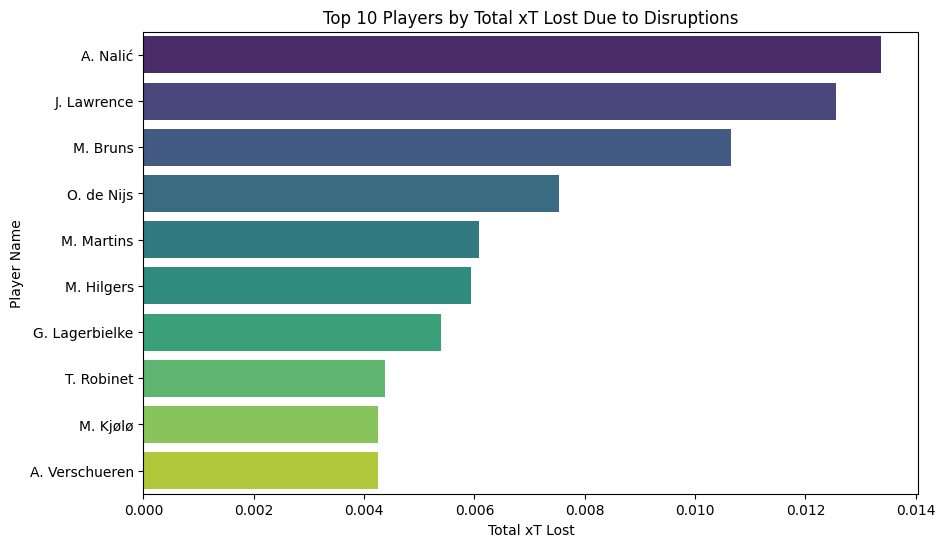

In [36]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import atan2

# Step 1: Load and Prepare the Data
# Load the main data from the CSV file
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Twente 1-0 Almere.csv")
type_cols = [col for col in df.columns if '/qualifierId' in col]

# Initialize 'endX' and 'endY' columns with 0.0
df['endX'] = 0.0
df['endY'] = 0.0
# Step 2: Load xT Grid
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape
print("xT grid dimensions:", xT_rows, xT_cols)

# Step 3: Bin Coordinates into xT Grid Zones
df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

# Step 4: Calculate xT for Each Pass
df['start_zone_value'] = df.apply(lambda row: xT[row['y1_bin'], row['x1_bin']], axis=1)
df['end_zone_value'] = df.apply(lambda row: xT[row['y2_bin'], row['x2_bin']], axis=1)
df['xT'] = df['end_zone_value'] - df['start_zone_value']

# Step 5: Calculate xPass for Each Pass
df['distance'] = np.sqrt((df['endX'] - df['x']) ** 2 + (df['endY'] - df['y']) ** 2)
df['angle'] = np.abs(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))
df['xPass'] = 1 - (0.02 * df['distance'] + 0.1 * df['angle'])
df['xPass'] = df['xPass'].clip(0, 1)  # Clip xPass to be between 0 and 1

# Step 6: Identify Defensive Interventions
defensive_actions = ['7', '8']  # Replace with actual event type IDs for defensive actions
df['defensive_intervention'] = df['typeId'].astype(str).isin(defensive_actions)

# Step 7: Add xT and xPass Lost for Disrupted Passes
df['xT_lost'] = df.apply(lambda row: row['xT'] if row['defensive_intervention'] else 0, axis=1)
df['xPass_lost'] = df.apply(lambda row: row['xPass'] if row['defensive_intervention'] else 0, axis=1)

# Step 8: Aggregate xT and xPass Lost by Player
player_disruption = df.groupby(['playerName', 'contestantId']).agg(
    total_disruptions=('defensive_intervention', 'sum'),
    total_xT_lost=('xT_lost', 'sum'),
    total_xPass_lost=('xPass_lost', 'sum')
).reset_index()

# Calculate xT and xPass lost per disruption
player_disruption['xT_lost_per_disruption'] = (
    player_disruption['total_xT_lost'] / player_disruption['total_disruptions']
)
player_disruption['xPass_lost_per_disruption'] = (
    player_disruption['total_xPass_lost'] / player_disruption['total_disruptions']
)

# Sort by total xT lost (most impactful disruptors)
player_disruption = player_disruption.sort_values(by='total_xT_lost', ascending=False)

# Step 9: Save Results to Excel
with pd.ExcelWriter("match_analysis_results.xlsx", mode="a", engine="openpyxl") as writer:
    player_disruption.to_excel(writer, sheet_name="Disruption Impact", index=False)

print("\nDisruption impact analysis saved to 'match_analysis_results.xlsx' in the 'Disruption Impact' sheet.")

# Step 10: Visualize the Results
# Plot top 10 players by total xT lost
top_10_xT_lost = player_disruption.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='total_xT_lost', 
    y='playerName', 
    data=top_10_xT_lost, 
    palette='viridis'
)
plt.title('Top 10 Players by Total xT Lost Due to Disruptions')
plt.xlabel('Total xT Lost')
plt.ylabel('Player Name')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       344
           1       0.00      0.00      0.00        13

    accuracy                           0.96       357
   macro avg       0.48      0.50      0.49       357
weighted avg       0.93      0.96      0.95       357

ROC AUC Score: 0.5117397137745975


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


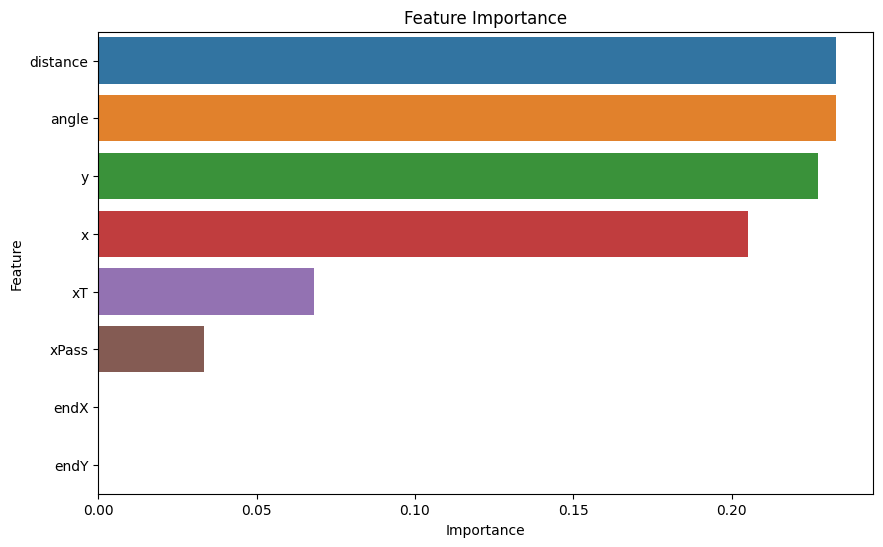


Model saved as 'disruption_model.pkl'.


In [38]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Prepare the Data
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Twente 1-0 Almere.csv")
type_cols = [col for col in df.columns if '/qualifierId' in col]

# Initialize 'endX' and 'endY' columns with 0.0
df['endX'] = 0.0
df['endY'] = 0.0
# Step 2: Feature Engineering
# Calculate xT and xPass (as shown earlier)
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

df['start_zone_value'] = df.apply(lambda row: xT[row['y1_bin'], row['x1_bin']], axis=1)
df['end_zone_value'] = df.apply(lambda row: xT[row['y2_bin'], row['x2_bin']], axis=1)
df['xT'] = df['end_zone_value'] - df['start_zone_value']

df['distance'] = np.sqrt((df['endX'] - df['x']) ** 2 + (df['endY'] - df['y']) ** 2)
df['angle'] = np.abs(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))
df['xPass'] = 1 - (0.02 * df['distance'] + 0.1 * df['angle'])
df['xPass'] = df['xPass'].clip(0, 1)

# Step 3: Define Target Variable
# Assume 'defensive_intervention' column indicates disruptions (1 = disruption, 0 = no disruption)
df['defensive_intervention'] = df['typeId'].astype(str).isin(['7', '8']).astype(int)  # Adjust typeId as needed

# Step 4: Select Features and Target
features = ['xT', 'xPass', 'distance', 'angle', 'x', 'y', 'endX', 'endY']
X = df[features]
y = df['defensive_intervention']

# Step 5: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluate the Model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of disruption

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Step 8: Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 9: Save the Model
import joblib
joblib.dump(model, "disruption_model.pkl")

print("\nModel saved as 'disruption_model.pkl'.")

In [41]:
# Load the saved model
model = joblib.load("disruption_model.pkl")

# Example: Predict disruption probability for a new pass
new_pass = pd.DataFrame({
    'xT': [0.3],
    'xPass': [0.8],
    'distance': [20],
    'angle': [0.5],
    'x': [50],
    'y': [30],
    'endX': [30],
    'endY': [40]
})

disruption_probability = model.predict_proba(new_pass)[:, 1]
print("Probability of disruption:", disruption_probability[0])

Probability of disruption: 0.11
